In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
import sklearn
from sklearn.model_selection import train_test_split

import xgboost as xg
from sklearn.ensemble import AdaBoostRegressor

In [2]:
oil_futures_path = './crude_oil_futures.csv'
gasoline_path = './gasoline.csv'

oil_futures = pd.read_csv(oil_futures_path)
gasoline = pd.read_csv(gasoline_path)

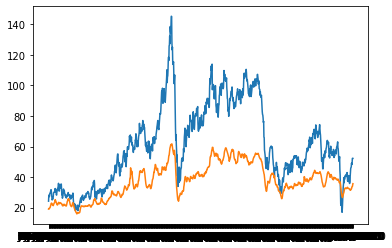

In [3]:
gasoline_start_index = gasoline[gasoline['Date'] == 'Jan 03, 2000'].index.values[0]
gas_df = gasoline[gasoline_start_index:]
df_date = gas_df['Date'].reset_index(drop=True)
df_oil_futures = oil_futures['Price'][::-1].reset_index(drop=True)
df_gas = gas_df['Weekly U.S. Regular All Formulations Retail Gasoline Prices  (Dollars per Gallon)'].reset_index(drop=True)
df = pd.DataFrame({ 'Week': df_date, 'oil_futures': df_oil_futures, 'gasoline': df_gas })

plt.plot(df['Week'], df['oil_futures'])
plt.plot(df['Week'], df['gasoline'] * 15)
plt.show()

In [4]:
periods = (1, 2, 3, 5, 10)

for p in periods:
    df['of_chg_{}'.format(p)] = df['oil_futures'].pct_change(periods=p)

df['gas_chg_1'] = df['gasoline'].pct_change()

df = df[11:]  # The first 10 rows contains NaN

In [5]:
chgs = ['of_chg_{}'.format(i) for i in periods]
X = df[['oil_futures'] + chgs].values
X

array([[ 2.80200000e+01, -9.34972501e-02, -1.17758186e-01,
        -1.10758489e-01, -5.04913589e-02,  0.00000000e+00],
       [ 2.69000000e+01, -3.99714490e-02, -1.29731478e-01,
        -1.53022670e-01, -1.13673806e-01, -4.60992908e-02],
       [ 2.50400000e+01, -6.91449814e-02, -1.06352605e-01,
        -1.89906179e-01, -2.05331641e-01, -8.00881705e-02],
       ...,
       [ 5.22400000e+01,  7.66694147e-02,  8.31432718e-02,
         6.39511202e-02,  1.29269347e-01,  4.59625594e-01],
       [ 5.23600000e+01,  2.29709035e-03,  7.91426216e-02,
         8.56313498e-02,  1.24328967e-01,  4.09800754e-01],
       [ 5.22700000e+01, -1.71886937e-03,  5.74272588e-04,
         7.72877164e-02,  6.45621181e-02,  3.02516820e-01]])

In [6]:
y = df['gas_chg_1'].values
y

array([ 0.00130976, -0.01373447, -0.00331565, ...,  0.00267499,
        0.03023566,  0.02675874])

In [7]:
# Create training, validation, and test set

training_ratio = 0.7
#validation_ratio = 0.15
#test_ratio = 0.15
test_ratio = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, \
#     test_size=validation_ratio/(training_ratio+validation_ratio), random_state=42)

print("X_train shape:\t", X_train.shape)
print("X_test shape:\t", X_test.shape)
#print("X_val shape:\t", X_val.shape)
print("y_train shape:\t", y_train.shape)
#print("y_val shape:\t", y_val.shape)
print("y_test shape:\t", y_test.shape)

X_train shape:	 (761, 6)
X_test shape:	 (327, 6)
y_train shape:	 (761,)
y_test shape:	 (327,)


In [8]:
for i in range(X_train.shape[1]):
    X_train_of_mean = X_train[:,i].mean()
    X_train_of_std = X_train[:,i].std()
    
    # Normalize
    
    X_train[:,i] = (X_train[:,i] - X_train_of_mean) / X_train_of_std
    #X_val[:,i] = (X_val[:,i] - X_train_of_mean) / X_train_of_std
    X_test[:,i] = (X_test[:,i] - X_train_of_mean) / X_train_of_std

In [19]:
dmatrix_train = xg.DMatrix(data=X_train, label=y_train)
dmatrix_test = xg.DMatrix(data=X_test, label=y_test)
param = { 'booster': 'gblinear', 'objective': 'reg:squarederror' }
xgb_regressor = xg.train(params=param, dtrain=dmatrix_train, num_boost_round=100)
y_pred = xgb_regressor.predict(dmatrix_test)

#y_pred
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.3921910289506444

In [12]:
from sklearn.metrics import mean_squared_error as MSE 

rmse = np.sqrt(MSE(y_test, y_pred))
rmse

0.016836589333500473

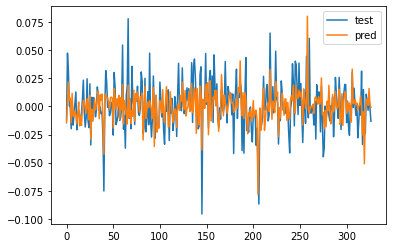

In [13]:
plt.plot(list(range(len(X_test))), y_test)
plt.plot(list(range(len(X_test))), y_pred)
plt.legend(['test', 'pred'])
plt.show()

In [14]:
regr = AdaBoostRegressor(random_state=0, n_estimators=100)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
#regr.score(X_test, y_test)

In [15]:
rmse = np.sqrt(MSE(y_test, y_pred))
rmse

0.016772699271757265

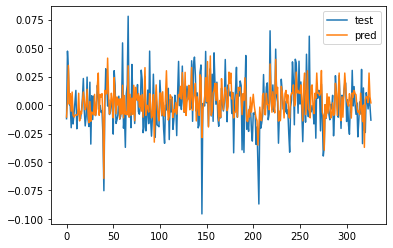

In [16]:
plt.plot(list(range(len(X_test))), y_test)
plt.plot(list(range(len(X_test))), y_pred)
plt.legend(['test', 'pred'])
plt.show()